### Metrics-2-Supplement
Auditing Error Calcs and adding `dist` metrics

In [18]:
import os, sys
import copy as copyroot
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from fastai2.basics import *
from fastai2.vision.all import *
%load_ext autoreload
%autoreload 2

from module.mnist_helpers import build_df, eda_fig_1, build_dls
from module.mnist_models import FeatsNet
from module.mnist_metrics import metrics_df

import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup

In [19]:
dls_tl = build_dls(target='topleft')
dls_cr = build_dls(target='center')

In [20]:
path = untar_data(URLs.MNIST_TINY)
df = build_df(path)

In [21]:
y_names = ['scalar_pxsum', 'point_topleft_x', 'point_topleft_y',
          'point_center_x', 'point_center_y']

df2 = pd.DataFrame([])
for i, row in df.iterrows():    
    img_np = np.array(Image.open(str(path) + row['fn'])).flatten()
    df2 = pd.concat((df2, pd.Series(img_np)), axis=1)
    
df2 = df2.T
df2.reset_index(inplace=True, drop=True)

df2_y = df[y_names]
df2 = pd.concat((df2, df2_y), axis=1)

df2.head(2)

,0,1,2,3,4,5,6,7,8,9,...,779,780,781,782,783,scalar_pxsum,point_topleft_x,point_topleft_y,point_center_x,point_center_y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,35867,11,5,15,14
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,29717,9,4,14,13


In [22]:
y_cols = y_names
x_cols = [col for col in df2.columns if col not in y_cols]

X = df2[x_cols]
Y = df2[y_cols]

y_tlx, y_tly, y_crx, y_cry = [Y.iloc[:,i] for i in range(1,5)]

Xt, Xv, yt_tlx, yv_tlx = train_test_split(X,  y_tlx, random_state=0)
_,  _,  yt_tly, yv_tly = train_test_split(X,  y_tly, random_state=0)
_,  _,  yt_crx, yv_crx = train_test_split(X,  y_crx, random_state=0)
_,  _,  yt_cry, yv_cry = train_test_split(X,  y_cry, random_state=0)

### Is R2 symmetric?

In [24]:
pred = [10,3,1]
actual = [1,3,1]
r2_score(actual, pred), r2_score(pred, actual)

(-29.374999999999996, -0.8134328358208953)

### Replicate Error Calcs

##### First, fit model, and perform exisitng calc
Here we turn off point scaling

In [7]:
model = Lasso(alpha=1.0)
model.fit(Xt, yt_crx)
preds_t = model.predict(Xt)
preds_vx = model.predict(Xv)

model = Lasso(alpha=1.0)
model.fit(Xt, yt_cry)
preds_ty = model.predict(Xt)
preds_vy = model.predict(Xv)

In [8]:
actuals = ([yv_crx.tolist(), yv_cry.tolist()],)
preds =   ([preds_vx, preds_vy], )

In [10]:
point_t = dls_cr.transform[1][1]
scale_t = dls_tl.after_item

point_t, scale_t

(TensorPoint.create: (object,object) -> create ,
 Pipeline: PointScaler -> ToTensor)

In [11]:
def my_scale(x): return scale_t(point_t(x))

In [12]:
def calc_dist(pred, actual):
    dist     = ((pred - actual)**2).sum(1)**0.5
    baseline = ((pred - actual.mean(0))**2).sum(1)**0.5
    
    dist_avg    = dist.mean().item()
    dist_r2     = 1 - (dist.sum() / baseline.sum()).item()
    sqdist_avg  = (dist**2).mean().item()
    sqdist_r2   = 1 - ((dist**2).sum() / (baseline**2).sum()).item()

    return (dist_avg, dist_r2, sqdist_avg, sqdist_r2)

In [13]:
data = []
for pred, actual in zip(preds, actuals):
    pred = my_scale(pred)
    actual = my_scale(actual)
#     pred = point_t(pred)
#     actual = point_t(actual)
    data.append((
        r2_score(actual, pred),
        mse(actual, pred).item(),
        mae(actual, pred).item(),
        *calc_dist(pred, actual),
    ))

In [14]:
data

[(0.8421148088774588,
  0.0019818737637251616,
  0.03359488025307655,
  0.05330542102456093,
  0.5872156322002411,
  0.003963747527450323,
  0.8025010675191879)]

##### Analyze Components
Looks like MSE is an average of the components

In [ ]:
actual.shape, pred.shape

In [ ]:
r2_score(actual, pred)

In [ ]:
r2_score(actual[:,0], pred[:,0]), r2_score(actual[:,1], pred[:,1])

In [ ]:
a,b = mse(actual[:,0], pred[:,0]), mse(actual[:,1], pred[:,1])
print(a,b)
(a + b) / 2

In [ ]:
mse(actual, pred), mean_squared_error(actual, pred)

#### Experments

In [ ]:
# synth_pred = torch.stack((pred[:,0], actual[:,1]))
synth_pred = torch.stack((pred[:,0], actual[:,1]))
synth_pred = synth_pred.permute((1,0))

In [ ]:
synth_pred.shape, actual.shape

In [ ]:
mse(synth_pred, actual)

In [ ]:
(actual_x - pred_x)**2 + (actual_y - pred_y)**2

#### We'll just compute a distance metric and do all metric calcs on that
Do we need a baseline distance calc?

In [ ]:
dist = ((pred - actual)**2).sum(1)**0.5

In [ ]:
dist_baseline = ((pred - actual.mean(0))**2).sum(1)**0.5

In [ ]:
(dist**2).mean()

In [ ]:
1 - ((dist**2).sum() / (dist_baseline**2).sum())

In [ ]:
dist.mean()

In [ ]:
dist_baseline.mean()

In [ ]:
1 - (dist.sum() / dist_baseline.sum())

In [ ]:
dist_baseline

In [ ]:
dist

In [ ]:
((dist)**2).sum(1)**0.5

In [ ]:
mse()

### Look at MSE ~ R2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
dir_fn = 'assets/metrics-dfs/'
df_lasso = pd.read_csv (dir_fn + 'metrics2-df-lasso.csv')
df_rf = pd.read_csv    (dir_fn + 'metrics2-df-rf.csv')

In [7]:
df_lasso

,model,details,split,r2_score,mse,mae,target
0,Lasso,alpha=1,train,0.909307,0.005253,0.046936,topleft
1,Lasso,alpha=1,train,0.920351,0.001006,0.023437,center
2,Lasso,alpha=1,valid,0.692450,0.017655,0.081952,topleft
3,Lasso,alpha=1,valid,0.842115,0.001982,0.033595,center


In [8]:
df_rf

,model,details,split,r2_score,mse,mae,target
0,RF,default params,train,0.975720,0.001409,0.018763,topleft
1,RF,default params,train,0.982754,0.000218,0.009266,center
2,RF,default params,valid,0.838002,0.009359,0.052582,topleft
3,RF,default params,valid,0.872646,0.001602,0.025845,center


In [14]:
tmp = df_lasso[df_lasso['target'] == 'topleft'][['r2_score','mse']]
tmp

,r2_score,mse
0,0.909307,0.005253
2,0.692450,0.017655


In [24]:
tmp['mse'][0]

0.005253153387457132

In [25]:
1 - (tmp['mse'][0]/baseline_mse)

0.8368585904516419

In [26]:
tmp

,r2_score,mse
0,0.909307,0.005253
2,0.692450,0.017655


In [15]:
tmp = df_rf[df_rf['target'] == 'center']
plt.scatter(tmp['dist_avg'] , tmp['dist_r2'])
plt.ylim(0,1); plt.xlim(0,.2)



NameError: name 'df_rf' is not defined

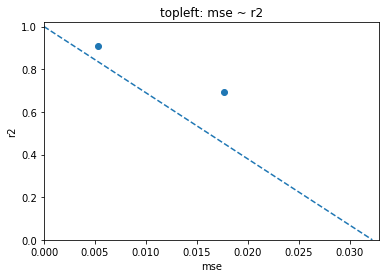

In [21]:
baseline_mse = 0.0322

plt.scatter(x=tmp['mse'],y=tmp['r2_score'])
plt.plot([0, baseline_mse], [1, 0], linestyle='--')
plt.xlim(0,baseline_mse*1.02)
plt.ylim(0,1*1.02)
plt.xlabel('mse')
plt.ylabel('r2')
plt.title('topleft: mse ~ r2');